# Deep learning workshop - Exercise 1


This exercise will take you through training of a deep neural network using Keras. 

We will train a network to classify cats and dogs.

We'll cover the following topics:
* Loading data
* Building a simpel Keras model
* Training a basic network
* Evaluation of the model performance

## Basics of Jupyter Notebooks

Cell types:
* Markdown cells: Cells like this one with markdown-text in it
     - Change highlighted cell to markdown with: `m`
* Code cells: Python code cells.
    - Change highlighted cell to code with: `y`

When highlighting cell:
* `shift + enter`: Run cell
* `enter`: Enter edit mode in cell
* `esc`: Exit edit mode in cell

From header above:
* `Kernel > Interrupt`: Stop long running cell ( you might need this if running too many epochs ).
* `Kernel > Restart`: Restart entire notebook, if it really messes up do this and re-run relevant cells.

In [24]:
## These are some helper functions to plot the outputs of our models. Run the cell to save the functions. 

def plot_training_epochs(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.epoch, history.history['acc'])
    plt.plot(history.epoch, history.history['val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    l = plt.legend(['training accuracy', 'validation accuracy'])

def plot_images_with_label(images, labels, class_):
    img_to_plot = images[labels[:, class_]==1, ...]

    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    for ax, img in zip(axes, img_to_plot):
        ax.imshow(array_to_img(img))
        ax.axis('off')
        
def print_confusion_matrix(y_true, y_hat):
    return pd.DataFrame(confusion_matrix(y_true, y_hat),
                        index=['true_' + cls for cls in classes],
                        columns=['pred_' + cls for cls in classes])

def rand_by_mask(mask, n=4):
    return np.random.choice(np.where(mask)[0], n, replace=False)

def rand_by_correct(is_correct, y_true, y_hat, n=4):
    return rand_by_mask((y_true == y_hat) == is_correct, n=n)

def plot_image_ids(image_ids, generator):
    images = np.array(generator.filenames)[image_ids]
    print("True classes: %s" % ' '.join(img.split('/')[0] for img in images))
    fig, axes = plt.subplots(1, len(images), figsize=(15, 10))
    for ax, img in zip(axes, images):
        image = load_img(path_to_data + '/valid/' + img)
        ax.imshow(image)
        ax.axis('off')

def plot_correct_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(True, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(classes[i] for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)

def plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(False, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(classes[i] for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)


## Loading data

First thing you need to do is load the data. In the following exercise you will work with a cats and dogs dataset.

In [25]:
cats_and_dogs_data = '/home/ubuntu/store/dogscats/1ksample'

# Change this to "cats_and_dogs_data" to use that dataset instead.
path_to_data = cats_and_dogs_data

In [26]:
# Load some of the things we need from keras
from keras.preprocessing.image import ImageDataGenerator          # generator to cycle through images
from keras.preprocessing.image import array_to_img                # function to convert arrays back to images 
from keras.applications.imagenet_utils import preprocess_input    # normalization function for ImageNet
from keras.preprocessing.image import load_img                    # function to load image

import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [53]:
## Set up some global variables
# Batch size is how many images the network looks at at a time
batch_size = 16

# The image size is what we should scale the images to
image_size = (224, 224)

# This is the number of classes to classify.
#    This is important for what the output of the network should look like.
#    In both cases we have two classes (dog/cat)
n_classes = 2

In [54]:
## Create data generators
# Create a generator that runs `preprocess_input` on every loaded image.
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the training and validation generators.
# They use the image sizes, batch sizes, and paths to data set above.
print('Load training.')
train_gen = data_generator.flow_from_directory(path_to_data + '/train',
                                               batch_size=batch_size,
                                               target_size=image_size)
print('\nLoad validation.')
valid_gen = data_generator.flow_from_directory(path_to_data + '/valid',
                                               batch_size=batch_size,
                                               target_size=image_size,
                                               shuffle=False)

# Create a list of classes sorted by index
classes = [cls[0] for cls in sorted(train_gen.class_indices.items(), key=lambda e: e[1])]

Load training.
Found 2125 images belonging to 2 classes.

Load validation.
Found 2000 images belonging to 2 classes.


The generators `train_gen` and `test_gen` will iterate over training and testing images. 

Each output will be a tuple of image-tensor and label-vector.

In [64]:
images, labels = next(train_gen)

Images here contains a tensor with shape:

`(batch_size, image_height, image_width, image_channels)`

In our case that is:

In [63]:
images.shape

(16, 224, 224, 3)

**Exercise**

Try plotting the first image:

The output of labels is a one-hot encoding of the class

The dictionary of the class can be seen in:

In [59]:
train_gen.class_indices

{'cats': 0, 'dogs': 1}

In [70]:
labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.]], dtype=float32)

The helper function:

`plot_images(images, labels, class)`

can plot the images from one of the classes (given the labels).

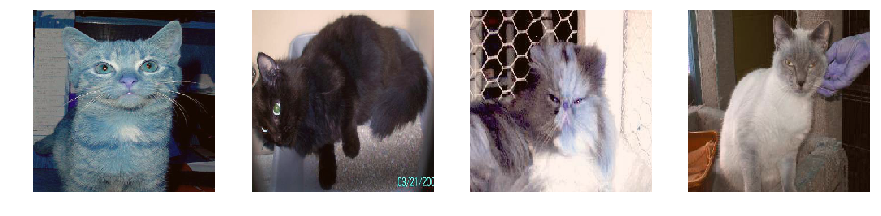

In [61]:
plot_images_with_label(images, labels, 0)

**Exercise**

Try plotting images from the other class (dogs):

## Build a basic network

Using some prefined Keras components you can build your own convolutional neural network. In the following section a simpel two layer network has been defined, including two convolutional layers, a flatten layer and a dense layer. 

The network will have two outputs (cats or dogs).

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

In [44]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 220, 220, 32)      18464     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1548800)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 3097602   
Total params: 3,117,858
Trainable params: 3,117,858
Non-trainable params: 0
_________________________________________________________________


## Train a basic network

To train the model you can run `model.fit_generator`

Every time the model has trained once on the training data it will evaluate it's accuracy on the validation data. The resulting training and validation accuracies are printed.

When you're done running this you can plot them. 

In [47]:
history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=2
)

Epoch 1/2
133/133 [==============================] - 28s 209ms/step - loss: 7.4878 - acc: 0.5320 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 2/2
133/133 [==============================] - 22s 166ms/step - loss: 7.5492 - acc: 0.5291 - val_loss: 8.0151 - val_acc: 0.5000


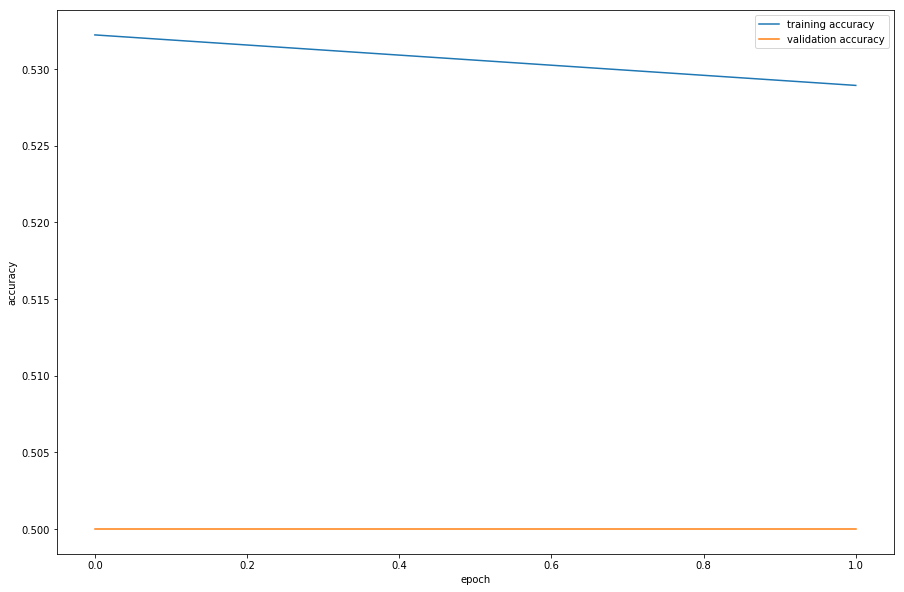

In [48]:
plot_training_epochs(history)

**Exercise**

Try increasing the number of epochs to run - can you get it to train?

## Evaluate the model performance

The first thing we want to do, when having trained a network is look at performance. We can see how the network does during training above. The orange line is the validation accuracy after each epoch.

But let's try and inspect the resulting predictions.

We use a confusion matrix, first:

In [49]:
# Get some metrics for evaluating the notebook
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

125/125 [==============================] - 9s 71ms/step


In [50]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat)

Accuracy: 0.5000
Confusion matrix:


,pred_cats,pred_dogs
true_cats,1000,0
true_dogs,1000,0


You can also plot random examples of correctly and incorrectly classified images using the cells below.

As they are randomized you can see more examples by rerunning the cells.

**Exercise**

Is there a pattern to the incorrectly classified examples?

Predictions: cats cats cats cats
True classes: dogs dogs dogs dogs


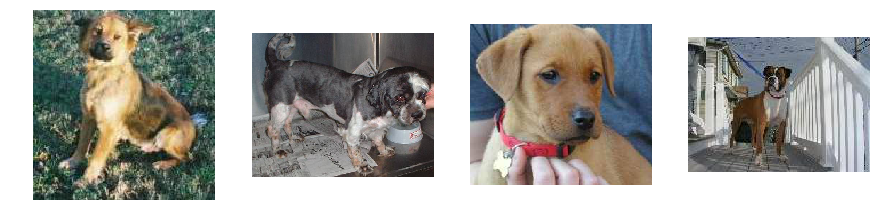

In [51]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

Predictions: cats cats cats cats
True classes: cats cats cats cats


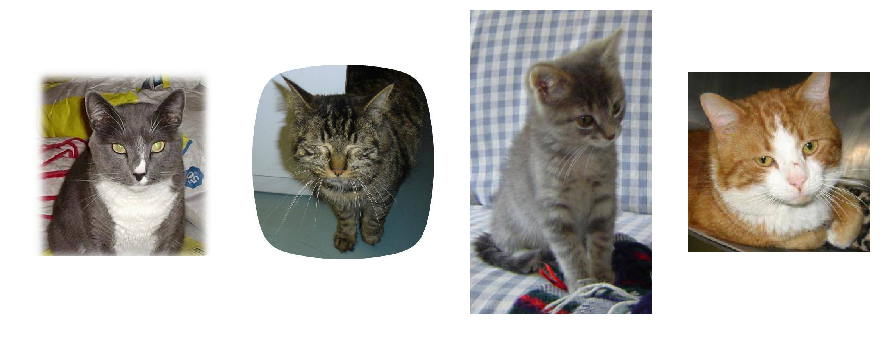

In [52]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)

**Exercise**

* What is the model performance?
* How can you increase the performance?
* Report the highest performance and the method used to get this.

## Feedback:

Please leave any feedback you migh have in the following text cell - then we'll try to improve our workshop for next time: